In [0]:
from google.colab import drive
drive.mount('/content/drive/')
prefix = './drive/My Drive/ND_CSE/Year_1/Research:Care-Net/code_and_data'
!echo "Project dir contents:" && ls "$prefix"
!echo -e "\nColab Notebook home dir:" && ls

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Project dir contents:
211_IN_Data_Parsing.ipynb    nd_care-net.tar.gz
BANE			     Node_Text_Embedding_Doc2Vec.ipynb
BANE_embeddings.ipynb	     Node_Text_Embedding_GPT-2-Copy1.ipynb
binder			     Node_Text_Embedding_sBERT.ipynb
CX_DB8			     README.md
data			     semantic_embeddings_cluster_plot.ipynb
embeddings		     service_embeddings_UMAP.ipynb
figures			     TENE
Graph_Data_Extraction.ipynb  TENE_embeddings.ipynb
models			     USE_multi_lang_embed_serv_sim_search.ipynb

Colab Notebook home dir:
drive  sample_data


In [0]:
import numpy as np
from sklearn.datasets import load_iris, load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import pickle
import json
import csv
import umap
%matplotlib inline
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

In [0]:
# config
NODE_TYPE = 'services'

MODEL = 'USE'
MODEL_URL = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3'
# MODEL_URL = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/2'
MODEL_TYPE = MODEL_URL.split('/')[-2]
MODEL_VER = MODEL_URL.split('/')[-1]

In [0]:
tagged_embeds = {}
embed_path = os.path.join(prefix, 'embeddings', MODEL, "{}_{}_v{}.pkl".format(
    NODE_TYPE, MODEL_TYPE, MODEL_VER
    ))
if os.path.exists(embed_path):
  print("Loading embeddings from {}".format(embed_path))
  with open(embed_path, 'rb') as f:
        tagged_embeds = pickle.load(f)

Loading embeddings from ./drive/My Drive/ND_CSE/Year_1/Research:Care-Net/code_and_data/embeddings/USE/services_universal-sentence-encoder-multilingual-large_v3.pkl


In [0]:
# open our datasets
with open(prefix + '/data/services_nodes.json') as sn:
    serv_nodes = json.loads(sn.read())
    
with open(prefix + '/data/services_edgelist.csv') as se:
    serv_edges = csv.reader(se)

# TODO: refacto var name to something more accurate and general
with open(prefix + '/data/HIN_nodes.json') as taxo:
    hin_nodes = json.loads(taxo.read())

with open(prefix + '/data/code_to_node_num.json') as cn:
    code_trans = json.loads(cn.read())

with open(prefix + '/data/code_to_name.json') as ctn:
    code_names = json.loads(ctn.read())

In [0]:
node_ids = list(tagged_embeds.keys())
node_names = list(map(lambda i: serv_nodes[i]['name'], node_ids))
# node_embeds = np.concatenate(list(tagged_embeds.values()), axis=0)
node_embeds = list(tagged_embeds.values())
node_embeds = list(map(lambda e: e['embed'], node_embeds))
node_embeds = np.stack(node_embeds, axis=0)
node_embeds.shape

(16547, 512)

In [0]:
reducer = umap.UMAP(metric="cosine", n_components=2, random_state=17)
%time embedding = reducer.fit_transform(node_embeds)

/usr/local/lib/python3.6/dist-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../usr/local/lib/python3.6/dist-packages/umap/utils.py", line 409:
@numba.njit(parallel=True)
def build_candidates(current_graph, n_vertices, n_neighbors, max_candidates, rng_state):
^

  current_graph, n_vertices, n_neighbors, max_candidates, rng_state
/usr/local/lib/python3.6/dist-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../usr/local/lib/python3.6/dist-packages/umap/nndes

CPU times: user 48.6 s, sys: 2.46 s, total: 51.1 s
Wall time: 46.2 s


In [0]:
embedding.shape

(16547, 2)

In [0]:
def node_to_n_degree_code(node_num, code_names, n=2):
  node = hin_nodes[node_num]
  codes = node['codes']
  main_code = None
  if len(codes) >= 1:
    main_code = codes[0]
    # main_code = main_code.split('-')[0]
    main_code = main_code[:n]
    # print(main_code)
    # print(main_code in code_names['2'])
    # assign a broad code as a node's "label"
    
    if main_code in code_names['1']:
      main_code = code_names['2'][main_code]
    elif main_code in code_names['2']:
      main_code = code_names['2'][main_code]
  else:
    main_code = "NULL"

    # print(main_code)
  
  return main_code

In [0]:
node_codes = [node_to_n_degree_code(idx, code_names) for idx in node_ids]
uniq_codes = set(node_codes)
code_to_label = {}
for i, code in enumerate(uniq_codes):
  code_to_label[code] = i

node_code_map = [code_to_label[code] for code in node_codes]

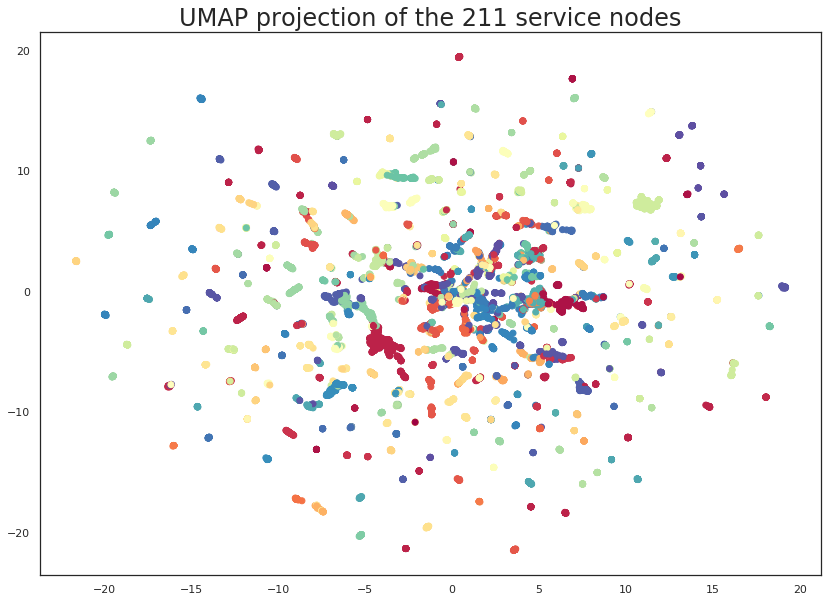

In [0]:
# plt.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], c=[sns.color_palette(n_colors=len(uniq_codes))[x] for x in node_code_map])
plt.scatter(embedding[:, 0], embedding[:, 1], c=[x for x in node_code_map], cmap='Spectral')
# plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the 211 service nodes', fontsize=24);

In [0]:
!pip3 install signature

ERROR: Could not find a version that satisfies the requirement signature (from versions: none)
ERROR: No matching distribution found for signature


In [0]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Dimension reduction and clustering libraries
import umap
# import hdbscan
import sklearn.cluster.KMeans
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

kmeans_labels = KMeans(n_clusters=10).fit_predict(node_embeds)
plt.scatter(embedding[:, 0], embedding[:, 1], c=kmeans_labels, s=0.1, cmap='Spectral');

ImportError: ignored

In [0]:
embedding.

AttributeError: ignored